In [1]:
from mapbox import Geocoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import random as rd
import ast
import re
import os

In [2]:
geocoder = Geocoder(access_token="pk.eyJ1IjoiZmFsdHVmYWx0dW1hc3QiLCJhIjoiY2pzZmtrMWdlMWZjYTQzbG5yMHllM2QzMCJ9.As3_2UKt_dWFBS7bS1SiGw")

def get_coordinates(address):
	response = geocoder.forward(address)
	try: return response.json()['features'][0]['geometry']['coordinates']
	except IndexError: return [None, None]

def refine(location):
	tokens = location.split(',')
	for x in range(len(tokens)):
		if re.search(r"\d\d\d\d\d\d", tokens[x]): return ''.join([tokens[y] for y in range(x - 2, x + 1)])

df_ngos = pd.ExcelFile('data/dataset.xlsx').parse('Sheet1')
df_class = pd.ExcelFile('data/dataset.xlsx').parse('Sheet2')

df_ngos['address'] = df_ngos['location'].apply(lambda x:refine(x))
df_ngos['coordinates'] = df_ngos['address'].apply(lambda x:get_coordinates(x))
df_ngos['class'] = df_ngos['class'].apply(lambda x:list(map(int,str(x).split(','))))

df_temp = pd.DataFrame(df_ngos.coordinates.tolist(), columns=['latitude', 'longitude'])
df_temp.index += 1
df_ngos['latitude'] = df_temp.loc[:,'latitude']
df_ngos['longitude'] = df_temp.loc[:,'longitude']
df_ngos = df_ngos.drop('location', axis=1)
df_ngos = df_ngos.drop('coordinates', axis=1)
df_ngos.fillna(0, inplace=True)
# df_ngos['class'] = df_ngos['class'].apply(lambda x:ast.literal_eval(x))

In [3]:
df_ngos.head()

,id,name,class,public_opinion,response_time,establishment_time,office_start,office_end,public_impact,address,latitude,longitude
0,1,All INDIA Human Right Protection,"[1, 2]",4.0,3.0,2008.0,1.0,0.0,5.0,Ceat Tyre Road Bhandup West Mumbai - 400078,0.000000,0.000000
1,2,Athurta Foundation,"[3, 5, 7]",4.0,0.0,2012.0,1000.0,1800.0,2.0,Off Marve Road Malad West mumbai - 400095,72.944110,19.154848
2,3,Save the Smile Social Foundation,"[12, 11, 10, 6, 8, 5]",4.0,3.0,2015.0,1000.0,1830.0,2.0,Nityanand Nagar Road Ghatkopar West Mumbai - ...,72.832630,19.180730
3,4,The Child Health Foundation,"[5, 12, 22]",4.4,0.0,2005.0,1000.0,1830.0,4.0,Kapad Bazar Road Mahim Mumbai - 400016,72.907800,19.090500
4,5,Om Laxmi Charitable Trust,"[4, 5, 12, 2, 8, 9, 22]",2.5,2.0,2018.0,7000.0,2000.0,1.0,Gandhi Nagar Link Road Kandivali West Mumbai ...,72.843932,19.040405


In [4]:
stakeholder_types = [0,1,2]
users = {
	'id': [1],
	'name': ['Rebecca Dsouza'],
	'age': [20],
	'stakeholder_type': [0],
	'preferences': [[5, 9, 10, 26]],
	'latitude':[72.84056],
	'longitude':[19.05444],
}

for _ in range(2,101):
	users['id'].append(_)
	users['name'].append('John Doe')
	users['age'].append(rd.randint(15, 70))
	users['stakeholder_type'].append(rd.randint(0, 2))
	users['preferences'].append([rd.randint(0, 43) for __ in range(rd.randint(2, 5))])
	users['latitude'].append(rd.uniform(72,77))
	users['longitude'].append(rd.uniform(18,19.5))

df_users = pd.DataFrame(users)

In [5]:
df_users.head()

,id,name,age,stakeholder_type,preferences,latitude,longitude
0,1,Rebecca Dsouza,20,0,"[5, 9, 10, 26]",72.840560,19.054440
1,2,John Doe,24,0,"[3, 17]",76.167541,18.692394
2,3,John Doe,62,1,"[39, 20]",74.120390,18.997704
3,4,John Doe,47,0,"[21, 6, 36]",75.374167,18.570522
4,5,John Doe,43,1,"[20, 1]",74.182606,19.318566


In [6]:
def p(ngo,user):
	# print(ngo['id'],user['id'])
	distance = ((user['latitude']-ngo['latitude'])**2 + (user['longitude']-ngo['longitude'])**2)**0.5 if [None,None] != [ngo['latitude'],ngo['longitude']] else 1000
	impact = ngo['public_impact'].item()
	class_intersect = len(set(user['preferences']).intersection(set(ngo['class'])))
	establishment_time = 2019 - ngo['establishment_time'].item()
	response_time = int(ngo['response_time']) if 'Nan' != ngo['response_time'] else 100
	public_opinion = ngo['public_opinion'].item()
	office_time = ngo['office_end'].item() - ngo['office_start'].item() if user['stakeholder_type'] == '0' else 0
	return -distance + impact + class_intersect + establishment_time - response_time + public_opinion - office_time

def comparison(ngo1_id,ngo2_id,user_id):
	ngo1 = df_ngos[df_ngos['id'] == ngo1_id].iloc[0]
	ngo2 = df_ngos[df_ngos['id'] == ngo2_id].iloc[0]
	usr = df_users[df_users['id'] == user_id].iloc[0]
	return 1 if p(ngo1,usr) > p(ngo2,usr) else -1

data = {
	'user_id': [],
	'ngo1_id': [],
	'ngo2_id': [],
	'phi': [],
}

for _,df_user in df_users.iterrows():
	temp = []
	for __,df_ngo in df_ngos.iterrows():
		if len(set(df_user['preferences']).intersection(set(df_ngo['class']))) > 0:
			temp.append(df_ngo['id'])
	for i,id1 in enumerate(temp,0):
		for j,id2 in enumerate(temp[i+1:],0):
			data['user_id'].append(df_user['id'])
			data['ngo1_id'].append(id1)
			data['ngo2_id'].append(id2)
			data['phi'].append(comparison(id1,id2,df_user['id']))

df_data = pd.DataFrame(data)

In [7]:
df_data.head()

,user_id,ngo1_id,ngo2_id,phi
0,1,2,3,1
1,1,2,4,-1
2,1,2,5,1
3,1,2,6,1
4,1,2,8,1


In [8]:
model_data = {
	'user_id':[],
	'user_age':[],
	'user_stakeholder_type':[],
	# 'user_preferences':[],
	'user_latitude':[],
	'user_longitude':[],
	'ngo1_id':[],
	# 'ngo1_class':[],
	'ngo1_public_opinion':[],
	'ngo1_response_time':[],
	'ngo1_establishment_time':[],
	'ngo1_office_start': [],
	'ngo1_office_end': [],
	'ngo1_public_impact': [],
	'ngo1_latitude': [],
	'ngo1_longitude':[],
	'ngo2_id':[],
	# 'ngo2_class':[],
	'ngo2_public_opinion':[],
	'ngo2_response_time':[],
	'ngo2_establishment_time':[],
	'ngo2_office_start': [],
	'ngo2_office_end': [],
	'ngo2_public_impact': [],
	'ngo2_latitude': [],
	'ngo2_longitude':[],
	'phi':[],
}

for __,_ in df_data.iterrows():
	u = df_users[df_users['id'] == _['user_id']].iloc[0]
	n1 = df_ngos[df_ngos['id'] == _['ngo1_id']].iloc[0]
	n2 = df_ngos[df_ngos['id'] == _['ngo2_id']].iloc[0]
	model_data['user_id'].append(u['id'])
	model_data['user_age'].append(u['age'])
	# model_data['user_preferences'].append(u['preferences'])
	model_data['user_stakeholder_type'].append(u['stakeholder_type'])
	model_data['user_latitude'].append(u['latitude'])
	model_data['user_longitude'].append(u['longitude'])

	model_data['ngo1_id'].append(n1['id'])
	# model_data['ngo1_class'].append(n1['class'])
	model_data['ngo1_public_opinion'].append(n1['public_opinion'])
	model_data['ngo1_response_time'].append(n1['response_time'])
	model_data['ngo1_establishment_time'].append(n1['establishment_time'])
	model_data['ngo1_office_start'].append(n1['office_start'])
	model_data['ngo1_office_end'].append(n1['office_end'])
	model_data['ngo1_public_impact'].append(n1['public_impact'])
	model_data['ngo1_latitude'].append(n1['latitude'])
	model_data['ngo1_longitude'].append(n1['longitude'])

	model_data['ngo2_id'].append(n2['id'])
	# model_data['ngo2_class'].append(n2['class'])
	model_data['ngo2_public_opinion'].append(n2['public_opinion'])
	model_data['ngo2_response_time'].append(n2['response_time'])
	model_data['ngo2_establishment_time'].append(n2['establishment_time'])
	model_data['ngo2_office_start'].append(n2['office_start'])
	model_data['ngo2_office_end'].append(n2['office_end'])
	model_data['ngo2_public_impact'].append(n2['public_impact'])
	model_data['ngo2_latitude'].append(n2['latitude'])
	model_data['ngo2_longitude'].append(n2['longitude'])
	model_data['phi'].append(_['phi'])

df_model_data = pd.DataFrame(model_data)

In [9]:
df_model_data.head()

,user_id,user_age,user_stakeholder_type,user_latitude,user_longitude,ngo1_id,ngo1_public_opinion,ngo1_response_time,ngo1_establishment_time,ngo1_office_start,...,ngo2_id,ngo2_public_opinion,ngo2_response_time,ngo2_establishment_time,ngo2_office_start,ngo2_office_end,ngo2_public_impact,ngo2_latitude,ngo2_longitude,phi
0,1,20,0,72.84056,19.05444,2,4.0,0.0,2012.0,1000.0,...,3,4.0,3.0,2015.0,1000.0,1830.0,2.0,72.832630,19.180730,1
1,1,20,0,72.84056,19.05444,2,4.0,0.0,2012.0,1000.0,...,4,4.4,0.0,2005.0,1000.0,1830.0,4.0,72.907800,19.090500,-1
2,1,20,0,72.84056,19.05444,2,4.0,0.0,2012.0,1000.0,...,5,2.5,2.0,2018.0,7000.0,2000.0,1.0,72.843932,19.040405,1
3,1,20,0,72.84056,19.05444,2,4.0,0.0,2012.0,1000.0,...,6,4.5,2.0,2014.0,1000.0,2000.0,2.0,72.835100,19.213467,1
4,1,20,0,72.84056,19.05444,2,4.0,0.0,2012.0,1000.0,...,8,3.5,3.0,2016.0,0.0,2359.0,2.0,10.419440,5.479440,1


In [10]:
X = df_model_data.iloc[:,0:22]
Y = df_model_data.iloc[:,23]
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.90%


In [11]:
X

,user_id,user_age,user_stakeholder_type,user_latitude,user_longitude,ngo1_id,ngo1_public_opinion,ngo1_response_time,ngo1_establishment_time,ngo1_office_start,...,ngo1_latitude,ngo1_longitude,ngo2_id,ngo2_public_opinion,ngo2_response_time,ngo2_establishment_time,ngo2_office_start,ngo2_office_end,ngo2_public_impact,ngo2_latitude
0,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,3,4.0,3.0,2015.0,1000.0,1830.0,2.0,72.832630
1,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,4,4.4,0.0,2005.0,1000.0,1830.0,4.0,72.907800
2,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,5,2.5,2.0,2018.0,7000.0,2000.0,1.0,72.843932
3,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,6,4.5,2.0,2014.0,1000.0,2000.0,2.0,72.835100
4,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,8,3.5,3.0,2016.0,0.0,2359.0,2.0,10.419440
5,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,9,5.0,3.0,2005.0,0.0,2359.0,5.0,151.702656
6,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,11,4.0,3.0,1998.0,1000.0,1900.0,5.0,72.840560
7,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,14,4.5,3.0,2012.0,900.0,2100.0,1.0,8.000000
8,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,15,4.0,2.0,2015.0,900.0,1730.0,2.0,72.963330
9,1,20,0,72.840560,19.05444,2,4.0,0.0,2012.0,1000.0,...,72.944110,19.154848,16,3.5,2.0,2000.0,1000.0,2000.0,2.0,73.150000


In [ ]:
df_model_data.to_csv("final.csv")

In [ ]:
df_users.to_csv("users.csv")

In [ ]:
df_ngos.to_csv("ngos.csv")

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test.values, y_pred)

array([[7087,  107],
       [ 142, 4536]])

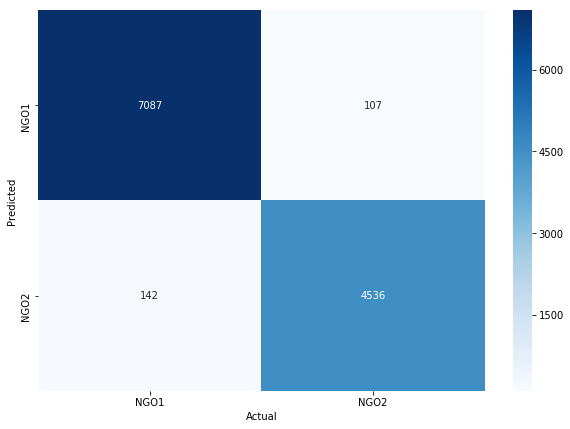

In [16]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


conf = confusion_matrix(y_test.values, y_pred)

df_cm = pd.DataFrame(conf, index = [i for i in ["NGO1","NGO2"]],columns = [i for i in ["NGO1","NGO2"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues',fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig("Confusion.png")
plt.show()